In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import sys
sys.path.append('..')

In [3]:
import math
import torch
import torch.nn.functional as F

class RMTBaseModel(torch.nn.Module):
    def __init__(self, base_model, **rmt_kwargs):
        super().__init__()
        self.model = base_model
        self.set_params(**rmt_kwargs)

    def set_params(self, num_mem_tokens, tokenizer, **rmt_config):
        self.rmt_config = rmt_config
        self.extract_special_tokens(tokenizer)
        self.extend_word_embeddings(num_mem_tokens, tokenizer)

        self.segment_size = rmt_config['input_size'] - num_mem_tokens - tokenizer.num_special_tokens_to_add()
        if 'sep_token' in tokenizer.special_tokens_map:
            self.segment_size -= 1

    def set_memory(self, input_shape):
        memory = self.model.embeddings(self.mem_token_ids)
        memory = memory.repeat(input_shape[0], 1, 1)
        return memory

    def extract_special_tokens(self, tokenizer):
        self.pad_token_id = tokenizer.pad_token_id
        self.special_token_ids = [tokenizer.pad_token_id]
        for token in ['cls_token', 'sep_token', 'eos_token', 'bos_token']:
            token_id = getattr(tokenizer, f'{token}_id')
            if token_id is not None:
                self.register_buffer(token, torch.tensor([token_id]))
                self.special_token_ids.append(token_id)
            else:
                setattr(self, token, None)

    def extend_word_embeddings(self, num_mem_tokens, tokenizer):
            
        vocab_size = self.model.config.vocab_size
        extended_vocab_size = vocab_size + num_mem_tokens
        self.num_mem_tokens = num_mem_tokens
        self.register_buffer('mem_token_ids', torch.arange(vocab_size, vocab_size + num_mem_tokens))
        self.model.resize_token_embeddings(extended_vocab_size)

        special_tokens = tokenizer.special_tokens_map
        mem_start_ind = int('cls_token' in special_tokens or 'bos_token' in special_tokens)
        self.memory_position = range(mem_start_ind, mem_start_ind + num_mem_tokens)
        self.model.embeddings = self.model.get_input_embeddings()

    def forward(self, **kwargs):
       raise NotImplementedError

    def pad_and_segment(self, input_ids):
        segmented_batch = []
        for seq in input_ids:
            drop_mask = sum([seq == t for t in self.special_token_ids])
            seq = seq[(1 - drop_mask).bool()]
            seq = seq[:self.segment_size * self.rmt_config['max_n_segments']]

            align = self.rmt_config.get('segment_alignment')
            if align in {'right', None}:
                split_inds = (list(range(len(seq), 0, -self.segment_size)) + [0])[::-1]
                input_segments = [seq[start:end] for (start, end) in zip(split_inds, split_inds[1:])]
            elif align == 'left':
                split_inds = list(range(0, len(seq), self.segment_size)) + [len(seq)]
                input_segments = [seq[start:end] for (start, end) in zip(split_inds, split_inds[1:])]
            else:
                n_seg = math.ceil(len(seq) / self.segment_size)
                input_segments = torch.chunk(seq, n_seg)

            input_segments = [self.pad_add_special_tokens(t, self.rmt_config['input_size']) for t in input_segments]

            # add empty segment markers if needed
            n_empty_segments = self.rmt_config['max_n_segments'] - len(input_segments)
            input_segments = [None] * n_empty_segments + input_segments

            segmented_batch.append(input_segments)

        segmented_batch = [[sample[seg_num] for sample in segmented_batch] \
                            for seg_num in range(self.rmt_config['max_n_segments'])]
        return segmented_batch

    def pad_add_special_tokens(self, **kwargs):
        raise NotImplementedError

    def prepare_kwargs(self, segment_input_ids, kwargs):
        seg_kwargs = dict(**kwargs)
        non_empty_mask = [s is not None for s in segment_input_ids]
        if sum(non_empty_mask) == 0:
            return None, non_empty_mask
            
        input_ids = torch.stack([s for s in segment_input_ids if s is not None])
        inputs_embeds = self.model.embeddings(input_ids)

        seg_kwargs['input_ids'] = None
        seg_kwargs['inputs_embeds'] = inputs_embeds
        if seg_kwargs.get('labels') is not None:
            seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]
        seg_kwargs['attention_mask'] = self.get_attention_mask(input_ids)
        if seg_kwargs.get('token_type_ids') is not None:
            seg_kwargs['token_type_ids'] = self.get_token_type_ids(input_ids)
        seg_kwargs['output_hidden_states'] = True

        return seg_kwargs, non_empty_mask

    def process_outputs(self, model_outputs, output_attentions, output_hidden_states):
        rmt_out = model_outputs[-1]

        segment_keys = ['loss']
        if output_attentions:
            segment_keys.append('attentions')
        if output_hidden_states:
            segment_keys.append('hidden_states')

        extracted = {}
        for seg_num, out in enumerate(model_outputs):
            for key, value in out.items():
                if any([sk in key for sk in segment_keys]):
                    extracted[f'{key}_{seg_num}'] = value

        if self.rmt_config['sum_loss']:
            losses = [out['loss'] for out in model_outputs]
            extracted['loss'] = torch.stack(losses).mean(dim=0)

        for key, value in extracted.items():
            rmt_out[key] = value
        
        # drop unnecessary hiddens to save memory
        if not output_hidden_states:
            for key in rmt_out.keys():
                if 'hidden_state' in key:
                    rmt_out[key] = None

        return rmt_out 
        
    def get_token_type_ids(self, tensor):
        return torch.zeros_like(tensor)

    def get_attention_mask(self, tensor):
        mask = torch.ones_like(tensor)
        mask[tensor == self.pad_token_id] = 0
        return mask

In [4]:
# from transformers import  AutoModel
# # m1 = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')
# m1 = AutoModel.from_pretrained('t5-base')
# m1.get_input_embeddings()

In [5]:
# import torch
# import torch.nn.functional as F
# from torch.nn import CrossEntropyLoss

# # from .base import RMTBaseModel
# class RMTDecoderForCausalLM(RMTBaseModel):
#     def extend_word_embeddings(self, num_mem_tokens, tokenizer):
            
#         vocab_size = self.model.config.vocab_size
#         extended_vocab_size = vocab_size + num_mem_tokens
#         self.num_mem_tokens = num_mem_tokens
#         self.register_buffer('mem_token_ids', torch.arange(vocab_size, vocab_size + num_mem_tokens))
#         self.model.resize_token_embeddings(extended_vocab_size)

#         self.read_memory_position = range(num_mem_tokens)
#         self.write_memory_position = range(-num_mem_tokens, 0)
#         self.model.embeddings = self.model.get_input_embeddings()

#     def set_memory(self, input_shape):
#         memory = self.model.embeddings(self.mem_token_ids)
#         memory = memory.repeat(input_shape[0], 1, 1)
#         return memory

#     def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
#                 inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
#         kwargs = {'attention_mask': attention_mask, 'token_type_ids': token_type_ids,
#                   'position_ids': position_ids, 'inputs_embeds': inputs_embeds,
#                   'labels': labels, 'output_attentions': output_attentions,
#                   'output_hidden_states': output_hidden_states, 'return_dict': return_dict,
#                   }

#         if not hasattr(self, 'memory_states') or self.memory_states is None:
#             init_memory = self.set_memory(input_ids.shape)
#             self.memory_states = [(None, init_memory)]
        
#         memory = self.memory_states[-1][1].detach()
#         memory.requires_grad = True

#         segment_input_ids = self.pad_and_segment(input_ids)[0]

#         seg_kwargs, non_empty_mask = self.prepare_kwargs(segment_input_ids, kwargs)
#         seg_kwargs['inputs_embeds'][:, self.read_memory_position] = memory
#         # seg_kwargs['inputs_embeds'][:, self.write_memory_position] = self.memory
        
#         labels = seg_kwargs.pop('labels')
#         out = self.model(**seg_kwargs)
        
#         new_memory = out.hidden_states[-1][:, self.write_memory_position]
#         self.memory_states.append((memory, new_memory))
#         self.trim_memory_states()

#         ### Calculate loss excluding memory 
#         lm_logits = out.logits[:, self.num_mem_tokens:-self.num_mem_tokens]
#         # Shift so that tokens < n predict n
#         shift_logits = lm_logits[..., :-1, :].contiguous()
#         shift_labels = labels[..., 1:].contiguous()
#         # Flatten the tokens
#         loss_fct = CrossEntropyLoss()
#         out['loss'] = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

#         return out

#     def pad_add_special_tokens(self, tensor, segment_size):
#         input_elements = []
#         input_elements += [self.mem_token_ids, tensor, self.mem_token_ids]
#         tensor = torch.cat(input_elements)

#         pad_size = segment_size - tensor.shape[0]
#         if pad_size > 0:
#             tensor = F.pad(tensor, (0, pad_size))
#         return tensor

#     def train(self, *args, **kwargs):
#         self.memory_states = None
#         super().train(*args, **kwargs)

#     def eval(self, *args, **kwargs):
#         self.memory_states = None
#         super().eval(*args, **kwargs)

#     def trim_memory_states(self):
#         k2 = self.rmt_config.get('k2')
#         if not k2 or k2 == -1:
#             return 
#         while len(self.memory_states) > k2:
#             del self.memory_states[0]

#     def truncated_backward(self, k1, k2):
#         memory_states = self.memory_states
#         if k1 != -1:
#             raise NotImplementedError
        
#         for i in range(k2 - 1 if k2 != -1 else len(memory_states)):
#             curr_grad = memory_states[-i-1][0].grad
#             memory_states[-i-2][1].backward(curr_grad, retain_graph=False)

#             # if we get all the way back to the "init_memory", stop
#             if memory_states[-i-2][0] is None:
#                 break


In [28]:
rmt.model.get_input_embeddings().weight.data[tokenizer.encode('.')].shape

torch.Size([1, 768])

In [31]:
rmt.memory 

Parameter containing:
tensor([[ 0.0543, -0.4447, -0.1340,  ...,  0.1870,  0.1497,  0.2828],
        [-0.2841,  0.1392,  0.2106,  ...,  0.1120,  0.1207,  0.1170],
        [-0.1804, -0.1462, -0.0555,  ...,  0.1288, -0.0955, -0.0859],
        ...,
        [-0.0821, -0.1621, -0.0228,  ...,  0.1952,  0.2123, -0.2015],
        [ 0.0587,  0.2174, -0.0653,  ...,  0.0208,  0.0308,  0.0730],
        [ 0.0777, -0.1794,  0.0564,  ...,  0.0466,  0.1506,  0.1847]],
       requires_grad=True)

In [34]:
rmt.model.get_input_embeddings().weight.data[tokenizer.encode('.')][0][0]

tensor(0.0466)

In [32]:
rmt.memory + rmt.model.get_input_embeddings().weight.data[tokenizer.encode('.')]

tensor([[ 0.1010, -0.4560, -0.1056,  ...,  0.1135,  0.1993,  0.3791],
        [-0.2375,  0.1278,  0.2389,  ...,  0.0385,  0.1703,  0.2133],
        [-0.1338, -0.1575, -0.0271,  ...,  0.0553, -0.0459,  0.0104],
        ...,
        [-0.0354, -0.1734,  0.0055,  ...,  0.1217,  0.2620, -0.1052],
        [ 0.1054,  0.2061, -0.0370,  ..., -0.0527,  0.0804,  0.1693],
        [ 0.1243, -0.1908,  0.0847,  ..., -0.0270,  0.2002,  0.2810]],
       grad_fn=<AddBackward0>)

In [38]:
from torch.nn import CrossEntropyLoss
class RMTDecoderLMHead(RMTBaseModel):
    def set_params(self, num_mem_tokens, tokenizer, **rmt_config):
        self.rmt_config = rmt_config
        self.extract_special_tokens(tokenizer)
        self.create_memory(num_mem_tokens, tokenizer)

        self.segment_size = rmt_config['input_size'] - 2 * num_mem_tokens - tokenizer.num_special_tokens_to_add()
        if 'sep_token' in tokenizer.special_tokens_map:
            self.segment_size -= 1

    def create_memory(self, num_mem_tokens, tokenizer):
        self.num_mem_tokens = num_mem_tokens
        embeddings = self.model.get_input_embeddings()
        memory_weights = torch.randn((num_mem_tokens, self.model.config.n_embd)) * embeddings.weight.data.std()\
                        + embeddings.weight.data[tokenizer.encode('.')]
        self.register_parameter('memory', torch.nn.Parameter(memory_weights, requires_grad=True))

        self.read_memory_position = range(num_mem_tokens)
        self.write_memory_position = range(-num_mem_tokens, 0)

    def set_memory(self, input_shape):
        memory = self.memory.repeat(input_shape[0], 1, 1)
        return memory

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        kwargs = {'attention_mask': attention_mask, 'token_type_ids': token_type_ids,
                  'position_ids': position_ids, 'inputs_embeds': inputs_embeds,
                  'labels': labels, 'output_attentions': output_attentions,
                  'output_hidden_states': output_hidden_states, 'return_dict': return_dict,
                  }

        if not hasattr(self, 'memory_states') or self.memory_states is None:
            init_memory = self.set_memory(input_ids.shape)
            self.memory_states = [(None, init_memory)]
        
        memory = self.memory_states[-1][1].detach()
        memory.requires_grad = True

        segment_input_ids = self.pad_and_segment(input_ids)[0]
        seg_kwargs, non_empty_mask = self.prepare_kwargs(segment_input_ids, memory, kwargs)
        
        labels = seg_kwargs.pop('labels')
        out = self.model(**seg_kwargs)
        
        new_memory = out.hidden_states[-1][:, self.write_memory_position]
        self.memory_states.append((memory, new_memory))
        self.trim_memory_states()

        ### Calculate loss excluding memory 
        lm_logits = out.logits[:, self.num_mem_tokens:-self.num_mem_tokens]
        # Shift so that tokens < n predict n
        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        # Flatten the tokens
        loss_fct = CrossEntropyLoss()
        out['loss'] = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return out

    def pad_add_special_tokens(self, tensor, segment_size):
        # pad_size = segment_size - tensor.shape[0]
        # if pad_size > 0:
        #     tensor = F.pad(tensor, (0, pad_size))
        return tensor
    
    def prepare_kwargs(self, segment_input_ids, memory, kwargs):
        seg_kwargs = dict(**kwargs)
        non_empty_mask = [s is not None for s in segment_input_ids]
        if sum(non_empty_mask) == 0:
            return None, non_empty_mask
            
        input_ids = torch.stack([s for s in segment_input_ids if s is not None])
        inputs_embeds = self.model.get_input_embeddings()(input_ids)
        inputs_embeds = torch.cat([memory, inputs_embeds, memory], dim=1)

        seg_kwargs['input_ids'] = None
        seg_kwargs['inputs_embeds'] = inputs_embeds
        if seg_kwargs.get('labels') is not None:
            seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]
        seg_kwargs['attention_mask'] = self.get_attention_mask(inputs_embeds)
        if self.rmt_config.get('offset_position_ids'):
            seg_kwargs['position_ids'] = self.get_offset_position_ids(input_ids)
        # if seg_kwargs.get('token_type_ids') is not None:
        #     seg_kwargs['token_type_ids'] = self.get_token_type_ids(inputs_embeds)
        seg_kwargs['output_hidden_states'] = True

        return seg_kwargs, non_empty_mask
    
    def get_offset_position_ids(self, tensor):
        # max_pos_id = min(self.model.config.max_position_embeddings, tensor.shape[1])
        max_pos_id = self.model.config.max_position_embeddings
        read_pos_ids = list(range(max_pos_id - self.num_mem_tokens, max_pos_id))
        write_pos_ids = list(range(max_pos_id - 2*self.num_mem_tokens, max_pos_id - self.num_mem_tokens))
        position_ids = read_pos_ids + list(range(tensor.shape[1])) + write_pos_ids
        position_ids = torch.tensor(position_ids, dtype=torch.long, device=tensor.device)
        return position_ids
    
    def get_attention_mask(self, tensor):
        mask = torch.ones(*tensor.shape[:2], dtype=torch.int64)
        mask[tensor == self.pad_token_id] = 0
        return mask

    def train(self, *args, **kwargs):
        self.memory_states = None
        super().train(*args, **kwargs)

    def eval(self, *args, **kwargs):
        self.memory_states = None
        super().eval(*args, **kwargs)

    def trim_memory_states(self):
        k2 = self.rmt_config.get('k2')
        if not k2 or k2 == -1:
            return 
        while len(self.memory_states) > k2:
            del self.memory_states[0]

    def truncated_backward(self, k1, k2):
        memory_states = self.memory_states
        if k1 != -1:
            raise NotImplementedError
        
        for i in range(k2 - 1 if k2 != -1 else len(memory_states)):
            curr_grad = memory_states[-i-1][0].grad
            memory_states[-i-2][1].backward(curr_grad, retain_graph=k2>2)

            # if we get all the way back to the "init_memory", stop
            if memory_states[-i-2][0] is None:
                break


# ------------------------------------------------------------------------------------

In [1]:
rmt

NameError: name 'rmt' is not defined

In [39]:
# num_segments = 1
# num_mem_tokens = 2
# device = torch.device(3)
device = 'cpu'

In [75]:
from transformers import AutoModel
model_name = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': 10, 
                'max_n_segments': 1,
               #  'segment_alignment': 'right',
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
               #  'reconstruction_loss_coef': 0.1,
                'offset_position_ids': True,
                'k1': -1, 'k2': 3,
                'segment_ordering': 'regular',
                'input_size': 1024, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

base_model = AutoModelForCausalLM.from_pretrained(model_name)
# base_model2 = AutoModelForCausalLM.from_pretrained(model_name)
# rmt = RMTDecoderForCausalLM(base_model, **rmt_config)
rmt = RMTDecoderLMHead(base_model, **rmt_config)

base_model3 = AutoModelForCausalLM.from_pretrained(model_name)
rmt_offset = RMTDecoderLMHead(base_model3, **rmt_config)
# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt = RMTEncoderHorizontalMemory(base_model, **rmt_config)
# rmt.to(device)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


# 籴

In [19]:
for n, p in rmt.named_parameters():
    if 'memory' in n:
        print(n)

memory


### How does loss differ when we add memory?

In [22]:
batch = next(gen)

In [23]:
base_out = base_model2(**batch)
base_out.keys(), base_out.loss

(odict_keys(['loss', 'logits', 'past_key_values']),
 tensor(3.3707, grad_fn=<NllLossBackward>))

In [24]:
# mem init from normal noise
rmt_out = rmt(**batch)
rmt_out.keys(), rmt_out.loss

(odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss']),
 tensor(3.4522, grad_fn=<NllLossBackward>))

In [52]:
# mem = normal noise + '.'
rmt_out = rmt(**batch)
rmt_out.keys(), rmt_out.loss

(odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss']),
 tensor(3.3839, grad_fn=<NllLossBackward>))

In [43]:
# mem = normal noise + '.'
# offset position ids
rmt_out = rmt(**batch)
rmt_out.keys(), rmt_out.loss

(odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss']),
 tensor(9.3534, grad_fn=<NllLossBackward>))

In [48]:
rmt.get_offset_position_ids(batch['input_ids'])[:15]

tensor([1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,    0,    1,
           2,    3,    4])

In [49]:
rmt.get_offset_position_ids(batch['input_ids'])[-20:]

tensor([ 994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003, 1004, 1005,
        1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013])

### What predictions differ?

In [83]:
preds = rmt_out.logits[0].argmax(dim=1)[10:-10]
base_preds = base_out.logits[0].argmax(dim=1)

In [56]:
preds.shape

torch.Size([1004])

In [55]:
preds[:10], base_preds[:10], batch['labels'][0][:10]

(tensor([  13,   13,   13,  290, 3859,  290,  287,  514,  257, 2863]),
 tensor([  262,    13,   284,   290,  3859, 11507,   287,   514,   257,  2863]),
 tensor([ 262, 3859, 1445,  837,  262, 2368,  983, 2921,  606,  257]))

In [58]:
preds[10:20], base_preds[10:20], batch['labels'][0][10:20]

(tensor([ 284,  651,  511,  511, 2180,  286,  286,  262,   12, 7496]),
 tensor([  284,  1592,   511,   511,  2180,   286,   286,   262, 18354,  7496]),
 tensor([ 2863,   284,  2987,  2402,   262,  1266,  3354,   286,   569, 18354]))

In [82]:
preds[20:30], base_preds[20:30], batch['labels'][0][20:30]

(tensor([262, 262, 198, 198, 262, 262, 262, 262, 262, 262]),
 tensor([17740,   764,   764,   284,   262,  1498,   262,   976,  3859,   355]),
 tensor([ 7496, 17740,  2873,  2233,   284,   852,   319,   262,   976,  3859]))

Text(0, 0.5, 'total num differences')

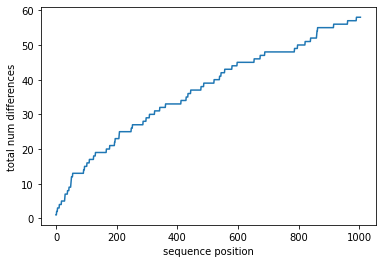

In [61]:
plt.plot(np.cumsum(preds != base_preds))
plt.xlabel('sequence position')
plt.ylabel('total num differences')

Text(0, 0.5, 'total num differences')

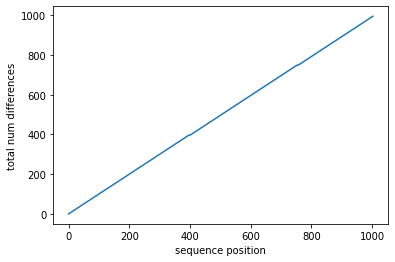

In [81]:
plt.plot(np.cumsum(batch['labels'][0] != base_preds))
plt.xlabel('sequence position')
plt.ylabel('total num differences')

In [147]:
preds.shape, base_preds.shape

(torch.Size([1024]), torch.Size([1004]))

In [ ]:
rmt_out = rmt(**batch)
rmt_out.keys(), rmt_out.loss

(odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss']),
 tensor(10.1318, grad_fn=<NllLossBackward>))

In [59]:
loss = rmt_out.loss
loss.backward(retain_graph=True)

In [60]:
rmt.truncated_backward(k1=-1, k2=rmt.rmt_config['k2'])


### add mem to checkpoint

In [62]:
# cpt = torch.load('../../runs/test/wikitext-2-v1/gpt2/lr5e-06_constant_with_warmup_adamw_wd1e-03_1004-1024-1x1024_mem10rw_bs32_iters25000_regular/run_1/model_best.pth', map_location='cpu')
cpt = torch.load('../../runs/test/wikitext-2-v1/gpt2/lr1e-05_linear_adamw_wd1e-03_1024-1024-1x1024_memNA_bs32_iters5000_constant_with_warmup/run_2/model_best.pth', map_location='cpu')

In [63]:
base_model2.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

In [64]:
base_out = base_model2(**batch)
base_out.keys(), base_out.loss

(odict_keys(['loss', 'logits', 'past_key_values']),
 tensor(2.7164, grad_fn=<NllLossBackward>))

In [65]:
rmt.model.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

In [76]:
rmt_offset.model.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

In [ ]:
base_out = base_model2(**batch)
base_out.keys(), base_out.loss

(odict_keys(['loss', 'logits', 'past_key_values']),
 tensor(2.7164, grad_fn=<NllLossBackward>))

In [66]:
rmt_out = rmt(**batch)
rmt_out.keys(), rmt_out.loss

(odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss']),
 tensor(7.2165, grad_fn=<NllLossBackward>))

In [79]:
rmt_offset_out = rmt_offset(**batch)
rmt_offset_out.keys(), rmt_offset_out.loss

(odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss']),
 tensor(6.9605, grad_fn=<NllLossBackward>))

In [67]:
preds = rmt_out.logits[0].argmax(dim=1)[10:-10]
base_preds = base_out.logits[0].argmax(dim=1)

In [80]:
tokenizer.decode(rmt_offset_out.logits[0].argmax(dim=1)[10:-10])

' the < to I first person of me the chance to defeat to the success of of the.ria, of and to the the the first as and The the to be and to the first to in the and and the in the defeatingunk < to first in was the byunk < tounk> to the the best was the by the < and andunk < to theunk> tounk> to theunk> wasunk> was theunk> wasunk> in theunk> andunk> and The < was the than the thanberness the was the appearance was The\n The first of the was by the in was the as as firstunk> < and < < of the of the the by the The with the is the in in by the first ands game and the of of made, and as the and were and < was and the game of the playable were were was The second of the is was the a characterunk> in and the of ins character in A the of the the < the first and of in the game game, the from and the were the the new and of the and and to the first to In are in to first of for the of the of they were not to the in were they the game to of the game iss is The first of are the to the in the of The 

Text(0, 0.5, 'total num differences')

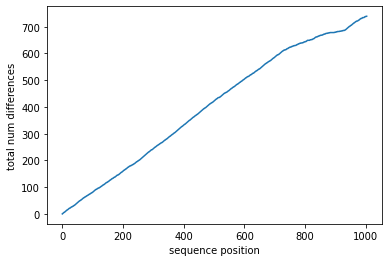

In [68]:
plt.plot(np.cumsum(preds != base_preds))
plt.xlabel('sequence position')
plt.ylabel('total num differences')

In [70]:
preds[:10], base_preds[:10], batch['labels'][0][:10]

(tensor([ 262,  262, 1445,  262,  262,  262,  262,  262,  262,  262]),
 tensor([ 262,  837,  764,  290, 1279, 2488,  287,  262,  257, 2863]),
 tensor([ 262, 3859, 1445,  837,  262, 2368,  983, 2921,  606,  257]))

In [71]:
preds[10:20], base_preds[10:20], batch['labels'][0][10:20]

(tensor([262, 262, 262, 262, 366, 198, 262, 262, 198, 198]),
 tensor([  284,  1592,   511,   511,  2180,   286,   286,   262, 18354,  7496]),
 tensor([ 2863,   284,  2987,  2402,   262,  1266,  3354,   286,   569, 18354]))

In [74]:
tokenizer.decode(preds[10:20])

' the the the the "\n the the\n\n'

In [63]:
# input_ids = tokenizer.batch_encode_plus(['one two three'], return_tensors='pt')
input_ids = tokenizer.batch_encode_plus(['Hamlet is written by William'], return_tensors='pt')

In [64]:
base_gen = base_model2.generate(**input_ids)
tokenizer.decode(base_gen[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Hamlet is written by William H. Haldane, Jr. and is published by Random House'

In [65]:
base_gen = rmt.generate(**input_ids)
tokenizer.decode(base_gen[0])

ModuleAttributeError: 'RMTDecoderLMHead' object has no attribute 'generate'

In [114]:
self = rmt
kwargs = dict(**batch)
input_ids = kwargs.pop('input_ids')

if not hasattr(self, 'memory_states') or self.memory_states is None:
    init_memory = self.set_memory(input_ids.shape)
    self.memory_states = [(None, init_memory)]

memory = self.memory_states[-1][1].detach()
memory.requires_grad = True

segment_input_ids = self.pad_and_segment(input_ids)[0]
seg_kwargs, non_empty_mask = self.prepare_kwargs(segment_input_ids, memory, kwargs)

labels = seg_kwargs.pop('labels')
out = self.model(**seg_kwargs)

new_memory = out.hidden_states[-1][:, self.write_memory_position]
self.memory_states.append((memory, new_memory))
self.trim_memory_states()

### Calculate loss excluding memory 
lm_logits = out.logits[:, self.num_mem_tokens:-self.num_mem_tokens]
# Shift so that tokens < n predict n
shift_logits = lm_logits[..., :-1, :].contiguous()
shift_labels = labels[..., 1:].contiguous()
# Flatten the tokens
loss_fct = CrossEntropyLoss()
out['loss'] = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

In [43]:
lm_logits = out.logits#[:, self.num_mem_tokens:-self.num_mem_tokens]
# Shift so that tokens < n predict n
shift_logits = lm_logits[..., :-1, :].contiguous()
shift_labels = labels[..., 1:].contiguous()
# Flatten the tokens
loss_fct = CrossEntropyLoss()
out['loss'] = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

In [115]:
seg_kwargs

{'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'input_ids': None,
 'inputs_embeds': tensor([[[-0.1061,  0.1165,  0.0298,  ..., -0.1810, -0.2925, -0.1364],
          [-0.1683,  0.0374,  0.2039,  ..., -0.0356, -0.0458,  0.1111],
          [ 0.0553, -0.1437,  0.1145,  ..., -0.0105,  0.0868,  0.1850],
          ...,
          [ 0.1295, -0.0475,  0.1125,  ...,  0.0758,  0.1263, -0.0608],
          [-0.0381,  0.0087,  0.0550,  ...,  0.0652,  0.0327,  0.0574],
          [ 0.1929, -0.0402, -0.1485,  ...,  0.2559, -0.1457,  0.0980]],
 
         [[-0.1061,  0.1165,  0.0298,  ..., -0.1810, -0.2925, -0.1364],
          [-0.1683,  0.0374,  0.2039,  ..., -0.0356, -0.0458,  0.1111],
          [ 0.0553, -0.1437,  0.1145,  ..., -0.0105,  0.0868,  0.1850],
          ...,
          [ 0.1295, -0.0475,  0.1125,  ...,  0.0758,  0.1263, -0.0608],
          [-0.0381,  0.0087,  0.0550,  ...,  0.0652,  0.0327,  0.0574],
          [ 0.1929, -0.0402, -0.1485,  ...,  0.2

In [ ]:
seg_kwargs

{'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'input_ids': None,
 'inputs_embeds': tensor([[[-0.6983,  0.2958,  0.0651,  ..., -0.4930,  0.1780, -0.1233],
          [-0.7090,  0.2899,  0.0687,  ..., -0.4936,  0.1388, -0.1367],
          [-0.8004,  0.2835,  0.0234,  ..., -0.4722,  0.1999, -0.2078],
          ...,
          [-0.6446,  0.2198,  0.2412,  ..., -0.4235,  0.2362, -0.1225],
          [-0.6449,  0.2472,  0.2796,  ..., -0.3957,  0.2449, -0.1895],
          [-0.8396,  0.1415,  0.2176,  ..., -0.4274,  0.2760, -0.1737]],
 
         [[-0.6246,  0.4268,  0.5278,  ..., -0.4032,  0.1377, -0.0916],
          [-0.5538,  0.4296,  0.5969,  ..., -0.4182,  0.1160, -0.0606],
          [-0.6343,  0.4200,  0.5665,  ..., -0.4097,  0.0908, -0.0699],
          ...,
          [-0.6150,  0.3819,  0.5284,  ..., -0.4078,  0.0855, -0.0581],
          [-0.6256,  0.3740,  0.5324,  ..., -0.4161,  0.0981, -0.0946],
          [-0.6823,  0.3452,  0.5308,  ..., -0.4

In [116]:
out.loss

tensor(11.3796, grad_fn=<NllLossBackward>)

In [88]:
rmt.memory_states[-][0].grad

AttributeError: 'NoneType' object has no attribute 'grad'

In [82]:
loss = out.loss
loss.backward()
rmt.truncated_backward(k1=-1, k2=rmt.rmt_config['k2'])

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [29]:
rmt_out = rmt(**batch)
rmt_out.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'loss'])

### load dataset 

In [14]:
class Holder:
    def __init__(self):
        pass

In [15]:
input_seq_len = 1024-20
target_seq_len = 1024-20
batch_size = 2

args = Holder
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
args.block_size = None

device = 'cpu'

### Decoder

In [16]:
from lm_experiments_tools.lm_datasets import *
raw_datasets = datasets.load_dataset('wikitext', 'wikitext-2-v1')
train_dataset, valid_dataset = get_lm_datasets(raw_datasets, tokenizer, block_size=args.input_seq_len)

Reusing dataset wikitext (/home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-8be6e4468e749f78.arrow
Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-536ebca993c930f8.arrow
Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-ae92410a4d5f252a.arrow
Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-f32cafc3f25787a5.arrow
Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-add9d6fc4881707e.a

In [17]:
from transformers import default_data_collator

# dataloader for RMT
# batch sample i is a continuation of sample i of the previous batch
class alignedDataLoader(DataLoader):
    def __iter__(self):
        all_inds = np.arange(len(self.dataset) // self.batch_size * batch_size)
        all_inds = all_inds.reshape(batch_size, -1)
        for batch_ind in range(all_inds.shape[1]):
            batch = [self.dataset[int(ind)] for ind in all_inds[:, batch_ind]]
            yield self.collate_fn(batch)


# shuffle train data each epoch (one loop over train_dataset)
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False,
#                                     drop_last=False, seed=args.seed)
# per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
# global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': 1}
train_dataloader = alignedDataLoader(train_dataset, batch_size=batch_size, 
                                # sampler=train_sampler,
                                collate_fn=default_data_collator, **kwargs)

In [18]:
# valid_sampler = DistributedSampler(valid_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False,
#                                         drop_last=True)
valid_dataloader = alignedDataLoader(valid_dataset, batch_size=batch_size, 
                            # sampler=valid_sampler,
                                collate_fn=default_data_collator, drop_last=True, **kwargs)

In [21]:
gen = iter(train_dataloader)
batch = next(gen)

In [32]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [33]:
batch['input_ids'].shape

torch.Size([2, 1022])

In [77]:
for batch in valid_dataloader:
    if batch['input_ids'].shape[0] != 2:
        print(batch['input_ids'].shape)

In [13]:
batch.keys(), batch['input_ids'].shape

(dict_keys(['input_ids', 'attention_mask', 'labels']), torch.Size([2, 1014]))

In [21]:
out = base_model(**batch)

KeyboardInterrupt: 

### old

In [35]:
from itertools import chain

In [36]:

column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]

def tokenize_function(examples):
    return tokenizer(examples[text_column_name])

# with accelerator.main_process_first():
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    # num_proc=args.preprocessing_num_workers,
    remove_columns=column_names,
    # load_from_cache_file=not args.overwrite_cache,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/5 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/37 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

In [37]:
if args.block_size is None:
    block_size = tokenizer.model_max_length
    if block_size > 1024:
        logger.warning(
            "The chosen tokenizer supports a `model_max_length` that is longer than the default `block_size` value"
            " of 1024. If you would like to use a longer `block_size` up to `tokenizer.model_max_length` you can"
            " override this default with `--block_size xxx`."
        )
    block_size = 1024
else:
    if args.block_size > tokenizer.model_max_length:
        logger.warning(
            f"The block_size passed ({args.block_size}) is larger than the maximum length for the model"
            f"({tokenizer.model_max_length}). Using block_size={tokenizer.model_max_length}."
        )
    block_size = min(args.block_size, tokenizer.model_max_length)

In [70]:
# Main data processing function that will concatenate all texts from our dataset and generate chunks of block_size.
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

# Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a remainder
# for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value might be slower
# to preprocess.
#
# To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
# https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map

# with accelerator.main_process_first():
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    # num_proc=args.preprocessing_num_workers,
    # load_from_cache_file=not args.overwrite_cache,
    desc=f"Grouping texts in chunks of {block_size}",
)

train_dataset = lm_datasets["train"]
eval_dataset = lm_datasets["validation"]

Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-7ac9ff3549af7c70.arrow
Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-99f09195a7ab805b.arrow
Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-540cd02db3d037a5.arrow


In [71]:
# tokenized_datasets['train'][4]

In [191]:
train_dataloader.collate_fn

<function torch.utils.data._utils.collate.default_collate(batch)>

In [234]:
class alignedDataLoader(DataLoader):
    def __iter__(self):
        all_inds = np.arange(len(self.dataset) // self.batch_size * batch_size)
        all_inds = all_inds.reshape(batch_size, -1)
        for batch_ind in range(all_inds.shape[1]):
            batch = [self.dataset[int(ind)] for ind in all_inds[:, batch_ind]]
            yield self.collate_fn(batch)


In [237]:

kwargs = {'pin_memory': True, 'num_workers': 0}
# train_dataloader = DataLoader(train_dataset, collate_fn=default_data_collator ,batch_size=batch_size, **kwargs)
train_dataloader = alignedDataLoader(train_dataset, collate_fn=default_data_collator, batch_size=batch_size, **kwargs)

In [238]:
gen = iter(train_dataloader)
batch = next(gen)

[   0  146  292  438  584  730  876 1022 1168 1314 1460 1606 1752 1898
 2044 2190]


In [226]:
# aligned
batch.keys(), batch['input_ids'].shape, batch['input_ids']

(dict_keys(['input_ids', 'attention_mask', 'labels']),
 torch.Size([16, 1024]),
 tensor([[  796,   569, 18354,  ...,   764,  2080,  5373],
         [  287,  3344,   837,  ...,   262,  2180,  1830],
         [  837,  2478,   670,  ...,   569, 18354,  7496],
         ...,
         [   31,   513,   284,  ...,    13,    31,   352],
         [  784,   352,  2488,  ...,   262,  2321,  9481],
         [21617, 13650, 22098,  ...,  9354,  6100,   764]]))

In [239]:
# aligned
batch = next(gen)
batch.keys(), batch['input_ids'].shape, batch['input_ids']


[   1  147  293  439  585  731  877 1023 1169 1315 1461 1607 1753 1899
 2045 2191]


(dict_keys(['input_ids', 'attention_mask', 'labels']),
 torch.Size([16, 1024]),
 tensor([[  287,  3344,   837,  ...,   262,  2180,  1830],
         [ 1031,   837,   290,  ...,   837,   543,  9179],
         [  286,  4463,  7750,  ...,   281,  2230,   284],
         ...,
         [ 5488,    89,   506,  ...,   691,  6989,   546],
         [ 1498,   284, 11169,  ...,   284, 48773,   837],
         [   29, 18280, 32876,  ...,  2488,    13,    31]]))

In [215]:
batch.keys(), batch['input_ids']

(dict_keys(['input_ids', 'attention_mask', 'labels']),
 tensor([[  796,   569, 18354,  ...,   764,  2080,  5373],
         [  287,  3344,   837,  ...,   262,  2180,  1830],
         [  837,  2478,   670,  ...,   569, 18354,  7496],
         ...,
         [   31,   513,   284,  ...,    13,    31,   352],
         [  784,   352,  2488,  ...,   262,  2321,  9481],
         [21617, 13650, 22098,  ...,  9354,  6100,   764]]))

In [245]:
base_model(**batch)

CausalLMOutputWithCrossAttentions(loss=tensor(3.3961, grad_fn=<NllLossBackward>), logits=tensor([[[ -37.5697,  -37.3806,  -39.4004,  ...,  -44.0468,  -43.9095,
           -36.3438],
         [ -50.8010,  -49.8145,  -52.7884,  ...,  -56.2524,  -58.1622,
           -50.2809],
         [ -87.8864,  -87.3851,  -91.0147,  ...,  -94.9864,  -98.1327,
           -87.0480],
         ...,
         [-229.1471, -228.0574, -230.0146,  ..., -244.3125, -243.3608,
          -230.1691],
         [-237.3444, -237.9768, -240.3638,  ..., -250.9469, -253.2148,
          -239.4103],
         [ -17.2615,  -18.7261,  -20.1312,  ...,  -24.7860,  -22.9559,
           -17.2196]],

        [[ -36.0355,  -36.1641,  -38.9063,  ...,  -43.8071,  -43.7380,
           -36.3379],
         [ -81.4318,  -80.5188,  -83.7899,  ...,  -90.4731,  -89.2782,
           -80.9288],
         [ -61.2699,  -59.7258,  -59.2438,  ...,  -68.4541,  -68.8881,
           -61.5544],
         ...,
         [-129.5234, -127.8208, -128.6255,  

In [103]:
gen = iter(train_dataloader)

In [104]:
batch = next(gen)

In [116]:
batch_size = 16

In [ ]:
self = train_dataloader
len(self.dataset)

2346

In [158]:
all_inds = np.arange(len(self.dataset) // batch_size * batch_size)

In [187]:
all_inds = all_inds.reshape(batch_size, -1)

In [188]:
for batch_ind in range(all_inds.shape[1]):
    batch = [self.dataset[int(ind)] for ind in all_inds[:, batch_ind]]
    break

In [189]:
batch

[{'input_ids': [796,
   569,
   18354,
   7496,
   17740,
   6711,
   796,
   220,
   198,
   2311,
   73,
   13090,
   645,
   569,
   18354,
   7496,
   513,
   1058,
   1279,
   2954,
   29,
   17740,
   357,
   4960,
   1058,
   10545,
   230,
   99,
   161,
   254,
   112,
   5641,
   44444,
   9202,
   25084,
   24440,
   12675,
   11839,
   18,
   837,
   6578,
   764,
   569,
   18354,
   7496,
   286,
   262,
   30193,
   513,
   1267,
   837,
   8811,
   6412,
   284,
   355,
   569,
   18354,
   7496,
   17740,
   6711,
   2354,
   2869,
   837,
   318,
   257,
   16106,
   2597,
   2488,
   12,
   31,
   2712,
   2008,
   983,
   4166,
   416,
   29490,
   290,
   6343,
   13,
   44206,
   329,
   262,
   14047,
   44685,
   764,
   28728,
   287,
   3269,
   2813,
   287,
   2869,
   837,
   340,
   318,
   262,
   2368,
   983,
   287,
   262,
   569,
   18354,
   7496,
   2168,
   764,
   1279,
   2954,
   29,
   262,
   976,
   21748,
   286,
   16106,
   290,
   1103,


In [ ]:

self.dataset[ind for ind in ]

In [166]:
all_inds

array([[   0,    1,    2, ...,  143,  144,  145],
       [ 146,  147,  148, ...,  289,  290,  291],
       [ 292,  293,  294, ...,  435,  436,  437],
       ...,
       [1898, 1899, 1900, ..., 2041, 2042, 2043],
       [2044, 2045, 2046, ..., 2187, 2188, 2189],
       [2190, 2191, 2192, ..., 2333, 2334, 2335]])

In [128]:
index_groups = [all_inds[bi::batch_size] for bi in range(batch_size)]

In [ ]:
np.arange(len(all))

In [134]:
index_groups[:, ]

2336

In [156]:
random_ind = np.random.randint(len(index_groups[0]))
random_ind

88

In [105]:
len(batch['input_ids'])

1024

In [78]:
slc = train_dataset[:2000]

In [83]:
len(slc['input_ids'])

2000

In [76]:
len(train_dataset)

2346

In [ ]:
batch_size = 32
rmt_batch_size = 

In [ ]:
batch = [train_dataset[i] for i in range(batch_size)]
# def collate_fn(batch):


In [55]:
from transformers import default_data_collator

In [50]:
len(batch[0]['input_ids']), batch[0].keys()

(1024, dict_keys(['input_ids', 'attention_mask', 'labels']))

In [57]:
collated = default_data_collator(batch)

In [59]:
collated['input_ids'].shape

torch.Size([2, 1024])

In [58]:
base_model(**collated)

CausalLMOutputWithCrossAttentions(loss=tensor(3.5045, grad_fn=<NllLossBackward>), logits=tensor([[[ -34.7663,  -34.2336,  -36.2633,  ...,  -41.4602,  -41.6725,
           -33.6455],
         [ -61.2569,  -60.4091,  -62.1589,  ...,  -72.6274,  -68.0054,
           -62.5463],
         [ -53.4921,  -52.9906,  -56.6589,  ...,  -64.8297,  -61.1910,
           -54.3980],
         ...,
         [-153.8063, -154.6980, -154.9599,  ..., -163.0337, -164.7416,
          -147.0979],
         [-118.5800, -116.7585, -118.8165,  ..., -121.1719, -124.4796,
          -117.3239],
         [-108.4291, -110.8208, -111.9854,  ..., -113.8714, -115.5268,
          -109.5036]],

        [[ -35.6724,  -35.2045,  -38.5079,  ...,  -40.9500,  -41.5535,
           -35.3343],
         [ -76.6815,  -78.0096,  -85.4610,  ...,  -88.2571,  -86.7574,
           -80.1590],
         [ -86.4675,  -86.0626,  -87.5999,  ...,  -89.8960,  -89.2970,
           -85.3141],
         ...,
         [-132.5101, -132.2510, -132.2406,  

In [12]:
global_attention_first_token = False  # should be True for LED
encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
generate_kwargs = {}

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    if 'outputs' in batch[0]:
        # if we have more than 1 label per example (only in valid) take only one of them
        # to compute loss on valid
        labels = [b['outputs'][0][:args.target_seq_len * 10] for b in batch]
    else:
        labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), max_length=args.input_seq_len, return_tensors='pt',
                                           **encode_plus_kwargs)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
                                             **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    features['id'] = [b['id'] for b in batch]
    if 'outputs' in batch[0]:
        features['target_text'] = [b['outputs'] for b in batch]
    else:
        features['target_text'] = [b['output'] for b in batch]
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features

In [13]:
task_name = 'qasper'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/qasper/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
gen = iter(train_dataloader)
sample = next(gen)

if 'id' in sample:
    id = sample.pop('id')
if 'target_text' in sample:
    tgt_text = sample.pop('target_text')

rmt.to(device)
for k in sample:
    sample[k] = sample[k].to(device)
    
sample_input_ids = sample.pop('input_ids').to(device)
kwargs = sample

### Encoder

In [14]:
input_seq_len = 1536
target_seq_len = 3
batch_size = 2

args = Holder
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [15]:
encode_plus_kwargs = {'max_length': args.input_seq_len,
                        'truncation': True,
                        'padding': 'longest',
                        'pad_to_multiple_of': 1}
generate_kwargs = {}
labels_map = {'Contradiction': 0, 'Entailment': 1, 'Not mentioned': 2}
num_labels = len(labels_map)

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs)
    labels = np.array([labels_map[t] for t in labels])
    features['labels'] = torch.from_numpy(labels)
    return features

In [16]:
task_name = 'contract_nli'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/contract_nli/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
gen = iter(train_dataloader)
sample = next(gen)

if 'id' in sample:
    id = sample.pop('id')
if 'target_text' in sample:
    tgt_text = sample.pop('target_text')

rmt.to(device)
for k in sample:
    sample[k] = sample[k].to(device)
    
sample_input_ids = sample.pop('input_ids').to(device)
kwargs = sample

In [24]:
out = rmt(sample_input_ids, **kwargs, output_hidden_states=True, output_attentions = True)
out.keys()

ModuleAttributeError: 'BertForSequenceClassification' object has no attribute 'encoder'

### replace forward signature

In [ ]:
import inspect 
from functools import wraps

model_name = "google/bert_uncased_L-4_H-256_A-4"

def decorate(func, source):
    @wraps(source)
    def decorated(*args, **kwargs):
        return func(*args, **kwargs)
    return decorated

class RMT(torch.nn.Module):
    def __init__(self, base_model, **rmt_kwargs):
        super().__init__()
        self.model = base_model
        self.forward = decorate(self.forward, self.model.forward)

    def forward(self, new_rmt_arg, input_ids, **kwargs):
        pass

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
rmt = RMT(base_model, **rmt_config)
inspect.signature(rmt.forward)

In [49]:
from functools import wraps

def wrap_func(method):
    @wraps(method)
    def _impl(self, *method_args, **method_kwargs):
        method_output = method(self, *method_args, **method_kwargs)
        return method_output
    return _impl
    # return 

class RMTEncoderForSequenceClassification(RMTBaseModel):
    def __init__(self, base_model, **rmt_kwargs):
        super().__init__(base_model, **rmt_kwargs)

    @wrap_func
    def forward(self, input_ids, **kwargs):
        memory = self.set_memory()
        memory = memory.repeat(input_ids.shape[0], 1, 1)
        segmented = self.pad_and_segment(input_ids)

        losses = []
        for seg_num, segment_input_ids in enumerate(segmented):                
            if (self.rmt_config['bptt_depth'] > -1) and (len(segmented) - seg_num > self.rmt_config['bptt_depth']): 
                memory = memory.detach()

            seg_kwargs = dict(**kwargs)
            seg_kwargs['output_hidden_states'] = True

            non_empty_mask = [s is not None for s in segment_input_ids]
            if sum(non_empty_mask) == 0:
                continue
            input_ids = torch.stack([s for s in segment_input_ids if s is not None])
            attention_mask = self.get_attention_mask(input_ids)
            token_type_ids = self.get_token_type_ids(input_ids)
            seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]

            inputs_embeds = self.model.embeddings(input_ids)
            inputs_embeds[:, self.memory_position] = memory[non_empty_mask]

            seg_kwargs['input_ids'] = None
            seg_kwargs['inputs_embeds'] = inputs_embeds
            seg_kwargs['attention_mask'] = attention_mask
            seg_kwargs['token_type_ids'] = token_type_ids

            out = self.model(**seg_kwargs)
            memory[non_empty_mask] = out.hidden_states[-1][:, self.memory_position]

            losses.append(out['loss'])

        # drop unnecessary hiddens to save memory
        if not kwargs.get('output_hidden_states'):
            for key in out.keys():
                if 'hidden_state' in key:
                    out[key] = None

        for i, l in enumerate(losses):
            out[f'loss_{i}'] = l.mean()

        if self.rmt_config['sum_loss']:
            out['loss'] = torch.stack(losses).sum(dim=0)

        return out
        
    def pad_add_special_tokens(self, tensor, segment_size):
        input_elements = []
        input_elements += [self.cls_token, self.mem_token_ids, self.sep_token, tensor, self.sep_token]
        tensor = torch.cat(input_elements)

        pad_size = segment_size - tensor.shape[0]
        if pad_size > 0:
            tensor = F.pad(tensor, (0, pad_size))
        return tensor
    
    def get_token_type_ids(self, tensor):
        return torch.zeros_like(tensor)


num_segments = 2
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'


from rmt_utils.encoder.memory_layers import memory_layers_forward as memory_layers_func
# from rmt_utils.encoder.memory_layers import deberta_memory_layers_forward as memory_layers_func

model_name = "google/bert_uncased_L-4_H-256_A-4"
# model_name = "microsoft/deberta-v3-base"
# model_name = 'google/electra-base-discriminator'
# model_name = "google/bert_uncased_L-4_H-256_A-4"

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': 5, 
                'max_n_segments': 3,
               #  'segment_alignment': 'right',
                'tokenizer': tokenizer,
                'memory_layers': 'all', 
                'memory_forward_func': memory_layers_func,
                'share_memory_layers': True,
                'reconstruction_loss_coef': 1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
rmt = RMTEncoderForSequenceClassification(base_model, **rmt_config)
# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt.to(device)

import inspect
inspect.signature(rmt.forward)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

<Signature (input_ids, **kwargs)>

### MLM head for input decoding 

In [140]:
self.model.bert.encoder.layer[-1]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=256, out_features=256, bias=True)
      (key): Linear(in_features=256, out_features=256, bias=True)
      (value): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=256, out_features=256, bias=True)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=256, out_features=1024, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=1024, out_features=256, bias=True)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [247]:
self.rec_attn = copy.deepcopy(self.model.base_model.encoder.layer[-1])
self.rec_cls = torch.nn.Linear(self.model.config.hidden_size, self.model.config.vocab_size)

In [146]:
rec_kwargs = dict(**kwargs)
rec_kwargs.pop('labels')
# rec_kwargs.pop('token_type')

tensor([2, 1])

In [269]:
mlm_prob = 0.15

segmented = self.pad_and_segment(sample_input_ids)
previous_input_ids = segmented[0]

inputs = torch.stack(previous_input_ids)
input_embeddings = self.model.embeddings(inputs)

out = self.model(inputs_embeds=input_embeddings, output_hidden_states=True)
memory_outputs = out['hidden_states'][-1][:, self.memory_position]


In [271]:
def reconstruction_forward(self, memory_outputs, previous_input_ids):
    
    inputs = torch.stack(previous_input_ids)
    input_embeddings = self.model.embeddings(inputs)
    input_embeddings[:, self.memory_position] = memory_outputs

    token_inds = list(range(self.num_mem_tokens + 2, input_embeddings.shape[1] - 1))
    mask_inds = np.random.choice(token_inds, round(len(token_inds) * mlm_prob))
    attention_mask = torch.ones(input_embeddings.shape[1])
    attention_mask[mask_inds] = 0

    rec_attn_out = self.rec_attn(input_embeddings)
    rec_logits = self.rec_cls(rec_attn_out[0])

    loss_fct = CrossEntropyLoss(ignore_index=-100)
    reconstruction_loss = loss_fct(rec_logits.view(-1, rec_logits.size(-1)), inputs.view(-1))
    
    return reconstruction_loss

In [272]:
reconstruction_forward(self, memory_outputs=memory_outputs, previous_input_ids=segmented[0])

tensor(10.4209, grad_fn=<NllLossBackward>)

In [254]:
token_inds = list(range(self.num_mem_tokens + 2, input_embeddings.shape[1] - 1))
mask_inds = np.random.choice(token_inds, round(len(token_inds) * mlm_prob))

In [266]:
attention_mask = torch.ones(input_embeddings.shape[1])
attention_mask[mask_inds] = 0


In [267]:
rec_attn_out = self.rec_attn(input_embeddings)
rec_logits = self.rec_cls(rec_attn_out[0])
rec_logits.shape

torch.Size([2, 512, 30527])

In [268]:
loss_fct = CrossEntropyLoss(ignore_index=-100)
reconstruction_loss = loss_fct(rec_logits.view(-1, rec_logits.size(-1)), inputs.view(-1))
reconstruction_loss

tensor(10.4209, grad_fn=<NllLossBackward>)

In [207]:
input_embeddings.shape

torch.Size([2, 512, 256])

In [239]:
token_inds = list(range(self.num_mem_tokens + 2, input_embeddings.shape[1] - 1))

In [240]:
np.random.shuffle(token_inds)
mask_inds = token_inds[: round(len(token_inds) * mlm_prob) ]

In [ ]:
input_a

In [ ]:
random_mask_inds = torch.randa


In [203]:
input_embeddings

tensor([[[-0.0159,  0.0027,  0.0078,  ...,  0.0175, -0.0240,  0.0109],
         [ 0.0315, -0.0055,  0.0017,  ...,  0.0132, -0.0214, -0.0158],
         [ 0.0016, -0.0042, -0.0412,  ...,  0.0192,  0.0082, -0.0007],
         ...,
         [-0.0986,  0.0014, -0.0430,  ..., -0.0016, -0.0158, -0.0046],
         [-0.0986,  0.0014, -0.0430,  ..., -0.0016, -0.0158, -0.0046],
         [-0.0986,  0.0014, -0.0430,  ..., -0.0016, -0.0158, -0.0046]],

        [[-0.0159,  0.0027,  0.0078,  ...,  0.0175, -0.0240,  0.0109],
         [ 0.0315, -0.0055,  0.0017,  ...,  0.0132, -0.0214, -0.0158],
         [ 0.0016, -0.0042, -0.0412,  ...,  0.0192,  0.0082, -0.0007],
         ...,
         [-0.0226,  0.0497,  0.0308,  ..., -0.0470, -0.0116,  0.0216],
         [-0.0381, -0.0252,  0.0037,  ...,  0.0464,  0.0336,  0.0329],
         [-0.0637, -0.0239,  0.0430,  ..., -0.0894,  0.0181,  0.0181]]],
       grad_fn=<EmbeddingBackward>)

In [148]:
rec_kwargs['token_type_ids'].shapea

torch.Size([2, 1536])

In [142]:
sample_input_ids

tensor([[ 101, 4909, 2283,  ...,    0,    0,    0],
        [ 101, 4909, 2283,  ..., 2023, 3820,  102]])

In [201]:
# from torch.nn import CrossEntropyLoss
# # def segment_reconstruction_forward(self, segmented, hidden_states):

# hidden_states = rec_kwargs['inputs_embeds']
# previous_input_ids = segmented[-2]
# non_empty_mask = [s is not None for s in previous_input_ids]
# if sum(non_empty_mask) == 0:
#     raise ValueError

# previous_input_ids = torch.stack(previous_input_ids)[non_empty_mask]
# reconstructor_input = hidden_states[non_empty_mask]

# rec_attn_out = self.rec_attn(reconstructor_input)
# rec_logits = self.rec_cls(rec_attn_out[0])

# loss_fct = CrossEntropyLoss(ignore_index=-100)
# reconstruction_loss = loss_fct(rec_logits.view(-1, rec_logits.size(-1)), previous_input_ids.view(-1))

### segment to memory attribution

In [18]:
self = rmt
input_ids = sample_input_ids

In [19]:
# memory = self.set_memory()
# memory = memory.repeat(input_ids.shape[0], 1, 1)
# segmented = self.pad_and_segment(input_ids)

# losses = {}
# memories = []
# inputs = []
# non_memory_position = [i for i in range(self.rmt_config['input_size']) if i not in self.memory_position]

# for seg_num, segment_input_ids in enumerate(segmented):
#     if (self.rmt_config['bptt_depth'] > -1) and (len(segmented) - seg_num > self.rmt_config['bptt_depth']): 
#         memory = memory.detach()

#     seg_kwargs = dict(**kwargs)
#     seg_kwargs['output_hidden_states'] = True
    
#     non_empty_mask = [s is not None for s in segment_input_ids]
#     if sum(non_empty_mask) == 0:
#         continue
#     input_ids = torch.stack(segment_input_ids)[non_empty_mask]
#     attention_mask = self.get_attention_mask(input_ids)
#     token_type_ids = self.get_token_type_ids(input_ids)
#     seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]

#     inputs_embeds = self.embeddings(input_ids)
#     inputs_embeds[:, self.memory_position] = memory[non_empty_mask]

#     seg_kwargs['inputs_embeds'] = inputs_embeds
#     seg_kwargs['attention_mask'] = attention_mask
        
#     out = self.model.forward(**seg_kwargs)

#     memory[non_empty_mask] = out.encoder_hidden_states[-1][:, self.memory_position]
    
#     memories.append(torch.clone(memory[non_empty_mask].detach()))
#     inputs.append(out.encoder_hidden_states[-1][:, non_memory_position])

#     losses[f'loss_{seg_num}'] = out['loss']

# memory_out = out.encoder_last_hidden_state[:, self.memory_position]
# reconstruction_loss = self.segment_reconstruction_forward(segmented, memory_out)
# out['reconstruction_loss'] = reconstruction_loss

# # drop unnecessary hiddens to save memory
# # if not kwargs.get('output_hidden_states'):
# #     for key in out.keys():
# #         if 'hidden_state' in key:
# #             out[key] = None
            
# for k, loss in losses.items():
#     out[k] = loss

# if self.rmt_config['sum_loss']:
#     out['loss'] = torch.stack(losses).sum(dim=0)

# rec_coef = self.rmt_config['reconstruction_loss_coef']
# out['loss'] = reconstruction_loss * rec_coef + out['loss'] * (1 - rec_coef)